In [ ]:
pip install catboost

In [ ]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cards = pd.read_csv('/content/drive/MyDrive/Credit Card//creditcard.csv')

# Первые строки датафрейма:
cards.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Основная информация по датафрейму:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Проверка кол-ва пропусков и дубликатов
print(f'Пропущено значений: {cards.isna().sum().sum()}')
print(f'Дубликатов: {cards.duplicated().sum()}')

Пропущено значений: 0
Дубликатов: 1081


In [ ]:
# Избавление от дубликатов
cards.drop_duplicates(inplace=True)
print(f'Дубликатов: {cards.duplicated().sum()}')

Дубликатов: 0


<Axes: >

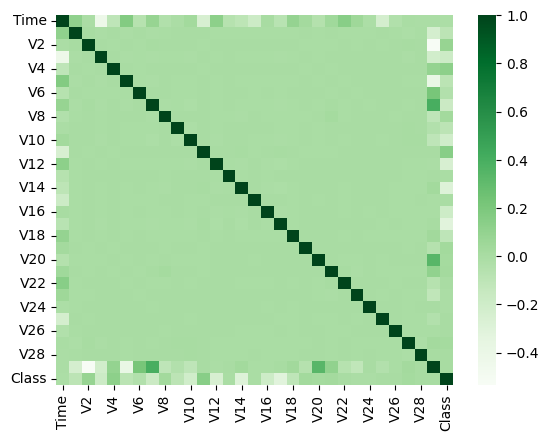

In [ ]:
# Оценка корреляции признаков
sns.heatmap(cards.corr(), cmap='Greens')

Корреляция между признаками *практически* отсутствует. Есть незначительная корреляция с признаками `Time`, `Amount`, `Class`.

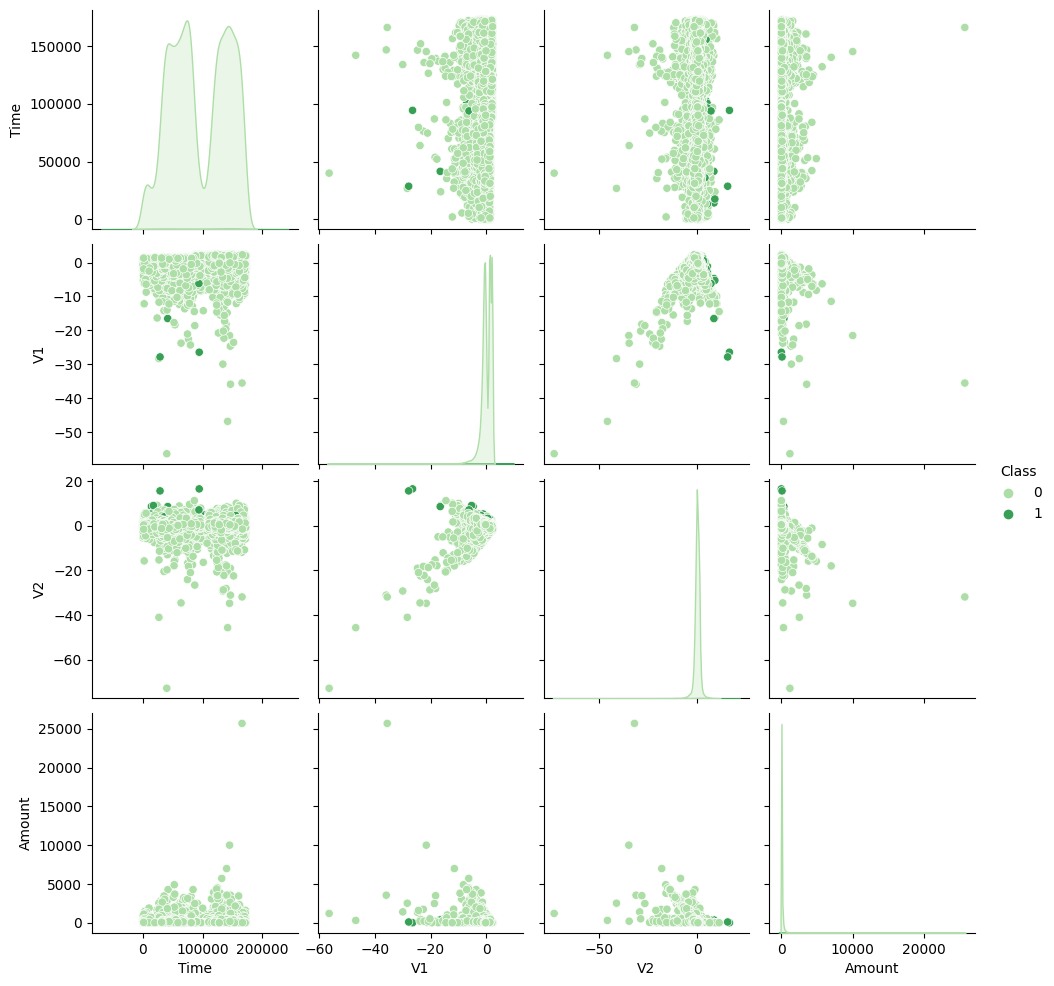

In [ ]:
# Исследование попарных зависимостей признаков на части данных (10 % данных)

sns.pairplot(cards.sample(frac=0.1).iloc[:, [0, 1, 2, 29, 30]], hue='Class', palette='Greens')

Уже на данном этапе можно оценить большую несбалансированность данных. Проверим это целенаправленно.

In [ ]:
# Сбалансированность данных между значениями Class
blnc = cards['Class'].value_counts().tolist()
print(f'Класс 0 - No fraud - {blnc[0]} - {blnc[0] / len(cards) * 100:.2f} % от данных')
print(f'Класс 1 - Fraud - {blnc[1]} - {blnc[1] / len(cards) * 100:.2f} % от данных')

Класс 0 - No fraud - 283253 - 99.83 % от данных
Класс 1 - Fraud - 473 - 0.17 % от данных


Данные сильно несбалансированы. Для проведения работ с несбалансированными данными возможно применить различные техники недо- и пресэмплирования.

In [ ]:
# Основные статистики по базе данных
cards.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


В решении будем сравнивать решения моделей логистической регрессии LogisticRegression и градиентный бустинг CatBoostClassifier.

In [ ]:
# Разделение данных для подготовки к ресэмплингу
X = cards.drop('Class', axis=1)
y = cards['Class']

print(X.shape[0], X.shape[1])
print(f'{y.mean()} - среднее значение целевой переменной')

283726 30
0.001667101358352777 - среднее значение целевой переменной


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=21)

In [ ]:
X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,...,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000
mean,94836.416116,0.004373,-0.002282,0.002391,-0.001912,0.002138,-0.002297,0.003069,-0.000886,-0.001844,...,-0.000695,0.000704,0.000549,-0.001213,-0.000617,-0.000785,0.000088,0.001608,0.000823,88.421188
std,47501.870342,1.949567,1.647473,1.512231,1.414906,1.377269,1.330829,1.234316,1.182425,1.092825,...,0.773549,0.733180,0.724949,0.627841,0.605835,0.521201,0.481176,0.396149,0.335876,251.951733
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.824849,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,54238.000000,-0.915958,-0.598318,-0.889075,-0.849342,-0.689313,-0.769401,-0.550953,-0.208972,-0.643125,...,-0.211321,-0.228063,-0.540371,-0.162158,-0.355417,-0.317359,-0.326418,-0.070656,-0.052836,5.530000
50%,84679.500000,0.017968,0.066546,0.181570,-0.021236,-0.052728,-0.275920,0.042400,0.022225,-0.052724,...,-0.062040,-0.028911,0.007666,-0.011527,0.040600,0.016368,-0.052624,0.001461,0.011361,22.000000
75%,139396.000000,1.314925,0.801615,1.028121,0.740531,0.612097,0.394844,0.571525,0.325891,0.595527,...,0.132947,0.185825,0.528568,0.147216,0.439048,0.349717,0.239584,0.091294,0.078563,77.520000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,19.587773,15.594995,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


Чтобы оценить качество полученных результатов, будем использовать метрики: сбалансированная точность и F1-мера. Выбор метрик обусловлен большой несбалансированностью данных.

## LogisticRegression

### Недосэмплирование

#### RandomUnderSampler

In [ ]:
# Недосэмплирование техникой RandomUnderSampler и сравнение данных
X_res, y_res = RandomUnderSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')
X_res.describe()

762 30
0.5 - среднее значение целевой переменной


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,...,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,87577.863517,-2.334318,1.670255,-3.425204,2.263444,-1.493737,-0.739097,-2.644338,0.456988,-1.296070,...,0.216471,0.261865,0.048473,-0.020996,-0.078464,-0.007982,0.012976,0.110416,0.042149,113.531404
std,47902.862599,5.314209,3.809853,6.002434,3.232262,4.157228,1.776384,5.674226,4.166367,2.286868,...,1.041107,2.148495,1.005654,1.205865,0.583127,0.693821,0.459477,0.976416,0.488626,337.426787
min,472.000000,-29.876366,-25.663628,-30.558697,-4.100941,-21.665654,-10.290874,-43.557242,-41.044261,-13.434066,...,-3.493050,-22.797604,-8.887017,-19.254328,-2.483598,-4.781606,-1.152671,-7.263482,-6.390338,0.000000
25%,46871.750000,-2.864065,-0.260048,-5.062954,-0.074908,-1.820316,-1.666685,-3.068777,-0.181630,-2.306005,...,-0.179748,-0.163909,-0.512406,-0.211749,-0.422506,-0.365153,-0.296801,-0.065168,-0.059090,1.525000
50%,80964.500000,-0.902577,0.942075,-1.241525,1.296676,-0.443035,-0.690719,-0.637405,0.158978,-0.691264,...,0.034855,0.174947,0.037718,-0.018690,-0.021834,0.028395,-0.040037,0.049929,0.035824,18.800000
75%,134345.750000,1.008446,2.805828,0.280875,4.240590,0.475089,0.086510,0.246512,0.858397,0.127190,...,0.454289,0.622056,0.566098,0.212972,0.372941,0.390870,0.321689,0.463119,0.243835,99.990000
max,172044.000000,2.323610,22.057729,3.620190,12.114672,16.560065,9.410864,18.585729,19.587773,3.897168,...,11.059004,27.202839,8.361985,5.466230,1.124557,2.156042,2.745261,5.866955,2.721853,6652.890000


In [ ]:
abs(X_train.describe()-X_res.describe()) # Сравнение сэмплированных и несэмплированных данных

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,...,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000
mean,7258.552599,2.338691,1.672537,3.427595,2.265355,1.495875,0.736799,2.647407,0.457874,1.294226,...,0.217166,0.261161,0.047924,0.019783,0.077846,0.007197,0.012888,0.108809,0.041326,25.110216
std,400.992258,3.364642,2.162380,4.490203,1.817356,2.779959,0.445556,4.439910,2.983942,1.194042,...,0.267558,1.415314,0.280705,0.578024,0.022708,0.172620,0.021699,0.580267,0.152750,85.475055
min,472.000000,26.531144,47.052099,17.766893,1.582230,92.077652,15.869632,0.000000,32.172458,0.000000,...,51.004671,12.032778,2.046127,25.553408,0.341251,5.513792,1.451879,15.302197,9.039746,0.000000
25%,7366.250000,1.948107,0.338270,4.173880,0.774434,1.131003,0.897284,2.517824,0.027342,1.662880,...,0.031572,0.064154,0.027965,0.049591,0.067090,0.047793,0.029617,0.005487,0.006254,4.005000
50%,3715.000000,0.920546,0.875529,1.423095,1.317912,0.390308,0.414799,0.679806,0.136753,0.638540,...,0.096895,0.203858,0.030052,0.007163,0.062434,0.012027,0.012587,0.048468,0.024463,3.200000
75%,5050.250000,0.306479,2.004213,0.747246,3.500058,0.137007,0.308334,0.325012,0.532506,0.468337,...,0.321342,0.436230,0.037530,0.065756,0.066107,0.041154,0.082106,0.371825,0.165272,22.470000
max,748.000000,0.128278,0.000000,5.762368,4.760672,18.241601,63.890762,102.003764,0.000000,11.697826,...,28.361900,0.000000,2.141105,17.062182,3.459992,5.363547,0.772085,25.745244,31.125954,19038.270000


In [ ]:
result = []

# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'RandomUnderSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomUnderSampler: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[54684  1970]
 [   19    73]]
RandomUnderSampler: Сбалансированная точность: 0.8793528911577677
RandomUnderSampler: F1-мера: 0.068384074941452


#### NearMiss 1

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=1).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')
X_res.describe()

762 30
0.5 - среднее значение целевой переменной


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,...,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,88267.312336,-2.250007,2.035083,-3.400592,2.286478,-1.398980,-0.781969,-2.669624,0.431929,-1.244177,...,0.218424,0.214370,0.040348,-0.073754,-0.048041,0.010354,0.029811,0.126093,0.044570,69.861640
std,50809.713027,5.227891,3.344289,5.998115,3.198619,4.074807,1.654100,5.595070,4.179771,2.345851,...,1.029265,2.120552,0.992584,1.219297,0.568794,0.673765,0.449493,0.944057,0.426732,198.673826
min,472.000000,-29.876366,-8.402154,-30.558697,-4.067605,-21.665654,-6.406267,-43.557242,-41.044261,-13.434066,...,-3.493050,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-2.085605,0.000000
25%,42055.000000,-2.786402,0.182766,-4.951307,0.003353,-1.642404,-1.618348,-3.054314,-0.201702,-2.326367,...,-0.184840,-0.216346,-0.554402,-0.229570,-0.390934,-0.327260,-0.267030,-0.052804,-0.052326,1.000000
50%,76871.000000,-0.773545,1.133857,-1.457279,1.308403,-0.299424,-0.735100,-0.601453,0.170978,-0.633816,...,-0.003067,0.133855,0.033940,-0.038361,0.006596,0.039587,0.030852,0.066353,0.035125,8.000000
75%,148040.500000,1.031972,2.840888,0.354657,4.220067,0.614311,-0.086561,0.262934,0.863595,0.190447,...,0.407237,0.622056,0.558663,0.176262,0.369005,0.392428,0.319246,0.467643,0.233939,31.937500
max,170348.000000,2.313171,22.057729,3.541039,12.114672,11.095089,6.474115,5.802537,19.587773,6.472920,...,11.059004,27.202839,8.361985,5.466230,3.274037,2.156042,2.745261,3.052358,1.779364,2125.870000


In [ ]:
abs(X_train.describe()-X_res.describe()) # Сравнение сэмплированных и несэмплированных данных

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,...,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000
mean,6569.103780,2.254380,2.037365,3.402983,2.288389,1.401118,0.779672,2.672693,0.432815,1.242333,...,0.219119,0.213666,0.039799,0.072541,0.047423,0.011140,0.029722,0.124485,0.043746,18.559548
std,3307.842685,3.278324,1.696815,4.485884,1.783713,2.697538,0.323271,4.360754,2.997346,1.253026,...,0.255716,1.387371,0.267635,0.591456,0.037041,0.152564,0.031683,0.547907,0.090856,53.277906
min,472.000000,26.531144,64.313574,17.766893,1.615566,92.077652,19.754239,0.000000,32.172458,0.000000,...,51.004671,12.032778,2.046127,25.553408,0.796825,5.513792,1.451879,15.302197,13.344479,0.000000
25%,12183.000000,1.870444,0.781084,4.062232,0.852695,0.953091,0.848946,2.503361,0.007270,1.683242,...,0.026480,0.011717,0.014031,0.067412,0.035517,0.009901,0.059388,0.017852,0.000510,4.530000
50%,7808.500000,0.791514,1.067312,1.638849,1.329639,0.246697,0.459181,0.643854,0.148753,0.581092,...,0.058972,0.162765,0.026274,0.026834,0.034004,0.023219,0.083475,0.064891,0.023764,14.000000
75%,8644.500000,0.282953,2.039273,0.673464,3.479536,0.002214,0.481405,0.308591,0.537704,0.405080,...,0.274290,0.436230,0.030095,0.029046,0.070044,0.042711,0.079663,0.376350,0.155376,45.582500
max,2444.000000,0.138718,0.000000,5.841520,4.760672,23.706577,66.827511,114.786957,0.000000,9.122074,...,28.361900,0.000000,2.141105,17.062182,1.310512,5.363547,0.772085,28.559840,32.068444,23565.290000


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'NearMiss_1: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_1: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[48176  8478]
 [   12    80]]
NearMiss_1: Сбалансированная точность: 0.8599600012892907
NearMiss_1: F1-мера: 0.018497109826589593


#### NearMiss 2

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=2).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')
X_res.describe()

762 30
0.5 - среднее значение целевой переменной


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,...,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,83743.227034,-2.266992,1.905777,-3.816237,2.023944,-1.123082,-0.807434,-2.421343,0.319574,-1.197447,...,0.241994,0.272385,0.156794,-0.038176,0.007001,-0.042478,0.068127,0.140752,0.030002,90.696444
std,34535.972527,5.211116,3.410372,5.751677,3.457711,4.213407,1.709763,5.718459,4.175657,2.332654,...,1.026259,2.136101,1.029225,1.189058,0.564399,0.675384,0.447626,0.932079,0.405703,209.298936
min,472.000000,-29.876366,-8.402154,-30.558697,-4.130727,-21.665654,-6.406267,-43.557242,-41.044261,-13.434066,...,-3.493050,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000
25%,73157.750000,-2.618029,0.042529,-4.928406,-0.628223,-1.565142,-1.735155,-3.022498,-0.319637,-2.287634,...,-0.168345,-0.163246,-0.491578,-0.246603,-0.341431,-0.370101,-0.244573,-0.060549,-0.074067,1.000000
50%,87179.500000,-0.944148,1.049027,-1.773476,1.159783,0.076640,-0.821894,-0.282769,0.092027,-0.533162,...,0.058910,0.249688,0.224030,-0.014356,0.024354,-0.094105,0.076361,0.096076,0.027708,10.000000
75%,87339.750000,0.451523,2.824201,-0.607634,4.232035,1.016804,-0.091583,0.758910,0.855756,0.332588,...,0.467433,0.673001,0.772226,0.223404,0.443680,0.337161,0.424823,0.470851,0.233939,99.887500
max,170348.000000,2.278934,22.057729,2.752925,12.114672,11.095089,6.474115,5.802537,19.587773,6.944031,...,11.059004,27.202839,8.361985,5.466230,1.226755,2.156042,2.745261,3.052358,1.779364,2125.870000


In [ ]:
abs(X_train.describe()-X_res.describe()) # Сравнение сэмплированных и несэмплированных данных

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,...,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000
mean,11093.189082,2.271365,1.908059,3.818628,2.025856,1.125220,0.805136,2.424412,0.320461,1.195603,...,0.242689,0.271682,0.156245,0.036963,0.007618,0.041693,0.068039,0.139144,0.029178,2.275255
std,12965.897814,3.261550,1.762899,4.239447,2.042806,2.836139,0.378934,4.484143,2.993231,1.239829,...,0.252710,1.402921,0.304276,0.561217,0.041436,0.154182,0.033550,0.535930,0.069826,42.652796
min,472.000000,26.531144,64.313574,17.766893,1.552444,92.077652,19.754239,0.000000,32.172458,0.000000,...,51.004671,12.032778,2.046127,25.553408,0.796825,5.513792,1.451879,15.302197,13.560793,0.000000
25%,18919.750000,1.702071,0.640847,4.039331,0.221119,0.875829,0.965753,2.471545,0.110665,1.644508,...,0.042975,0.064817,0.048793,0.084445,0.013986,0.052742,0.081845,0.010107,0.021230,4.530000
50%,2500.000000,0.962117,0.982481,1.955046,1.181019,0.129367,0.545974,0.325170,0.069802,0.480438,...,0.120950,0.278599,0.216365,0.002829,0.016246,0.110474,0.128984,0.094614,0.016347,12.000000
75%,52056.250000,0.863402,2.022586,1.635755,3.491504,0.404707,0.486427,0.187385,0.529865,0.262939,...,0.334486,0.487176,0.243658,0.076188,0.004632,0.012556,0.185240,0.379558,0.155376,22.367500
max,2444.000000,0.172954,0.000000,6.629633,4.760672,23.706577,66.827511,114.786957,0.000000,8.650964,...,28.361900,0.000000,2.141105,17.062182,3.357794,5.363547,0.772085,28.559840,32.068444,23565.290000


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'NearMiss_2: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_2: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[51053  5601]
 [   16    76]]
NearMiss_2: Сбалансированная точность: 0.8636118406006867
NearMiss_2: F1-мера: 0.026347720575489682


### Пересэмплирование

#### RandomOverSampler

In [ ]:
# Пересэмплирование техникой RandomOverSampler и сравнение данных
X_res, y_res = RandomOverSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')
X_res.describe()

453198 30
0.5 - среднее значение целевой переменной


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,...,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000
mean,87554.776572,-2.277037,1.750447,-3.418342,2.271201,-1.517188,-0.718477,-2.651240,0.448714,-1.289913,...,0.218617,0.248107,0.047439,-0.054677,-0.058331,0.012785,0.024263,0.116608,0.045809,108.225969
std,48571.222066,5.273984,3.579782,6.008994,3.217738,4.084257,1.715539,5.628756,4.178359,2.294972,...,1.101204,2.137862,1.001880,1.250162,0.565598,0.687630,0.474906,0.950697,0.445844,262.295439
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.824849,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,45541.000000,-2.830984,-0.138097,-5.047679,-0.106243,-1.796308,-1.602523,-3.059245,-0.199244,-2.328023,...,-0.181672,-0.163861,-0.524160,-0.241375,-0.401533,-0.328168,-0.288816,-0.060662,-0.054614,1.520000
50%,79449.000000,-0.805572,0.965681,-1.375886,1.311380,-0.448525,-0.658522,-0.626704,0.169178,-0.725689,...,0.033130,0.159387,0.037791,-0.034882,0.000090,0.046685,-0.013089,0.055918,0.035883,18.960000
75%,134931.000000,1.014298,2.793185,0.325437,4.233151,0.473032,0.081568,0.274661,0.859156,0.157720,...,0.468960,0.650988,0.576453,0.194142,0.363275,0.389869,0.324638,0.455179,0.225973,99.990000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,19.587773,15.594995,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


In [ ]:
abs(X_train.describe()-X_res.describe()) # Сравнение сэмплированных и несэмплированных данных

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,...,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000
mean,7281.639544,2.281410,1.752729,3.420733,2.273113,1.519326,0.716180,2.654309,0.449600,1.288069,...,0.219311,0.247404,0.046890,0.053463,0.057714,0.013571,0.024174,0.115000,0.044986,19.804781
std,1069.351724,3.324417,1.932308,4.496764,1.802832,2.706988,0.384710,4.394440,2.995934,1.202147,...,0.327655,1.404682,0.276930,0.622321,0.040237,0.166429,0.006270,0.554548,0.109968,10.343706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8697.000000,1.915026,0.460221,4.158605,0.743099,1.106994,0.833121,2.508292,0.009727,1.684898,...,0.029649,0.064202,0.016211,0.079217,0.046116,0.010809,0.037602,0.009994,0.001778,4.010000
50%,5230.500000,0.823540,0.899136,1.557456,1.332616,0.395798,0.382603,0.669104,0.146952,0.672965,...,0.095170,0.188298,0.030125,0.023355,0.040511,0.030317,0.039535,0.054457,0.024522,3.040000
75%,4465.000000,0.300626,1.991570,0.702684,3.492620,0.139065,0.313276,0.296863,0.533264,0.437807,...,0.336013,0.465163,0.047885,0.046926,0.075773,0.040152,0.085054,0.363886,0.147410,22.470000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'RandomOverSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomOverSampler: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[54762  1892]
 [   14    78]]
RandomOverSampler: Сбалансированная точность: 0.9072151933705898
RandomOverSampler: F1-мера: 0.07565470417070805


#### SMOTE

In [ ]:
# Пересэмплирование техникой SMOTE и сравнение данных
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')
X_res.describe()

453198 30
0.5 - среднее значение целевой переменной


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,...,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000,453198.000000
mean,87567.377216,-2.294642,1.808924,-3.482036,2.310709,-1.543537,-0.746426,-2.729250,0.491964,-1.323155,...,0.229961,0.244893,0.050719,-0.043179,-0.055796,0.012690,0.025914,0.120307,0.049905,100.078092
std,48548.603762,4.996896,3.385389,5.770034,3.141524,3.855813,1.611369,5.276749,3.827761,2.181647,...,0.999117,1.843441,0.905250,0.983861,0.540059,0.621313,0.442515,0.841800,0.404319,227.358970
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.824849,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,45603.762084,-2.992010,-0.093345,-5.109095,-0.051936,-1.851528,-1.564568,-3.193944,-0.180575,-2.320763,...,-0.178014,-0.154016,-0.486690,-0.220813,-0.377044,-0.320898,-0.270065,-0.064451,-0.051806,3.822504
50%,79322.000000,-0.845757,1.016839,-1.556314,1.471931,-0.479077,-0.702139,-0.745945,0.185737,-0.839920,...,0.059806,0.174867,0.036142,-0.025166,-0.008689,0.032919,-0.005584,0.064679,0.041005,26.835775
75%,134834.231603,0.768596,2.916874,0.261639,4.289668,0.405257,0.003698,0.188715,0.860977,0.072294,...,0.475860,0.654177,0.530388,0.188955,0.332812,0.366403,0.305674,0.440390,0.219252,99.990000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,19.587773,15.594995,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


In [ ]:
abs(X_train.describe()-X_res.describe()) # Сравнение сэмплированных и несэмплированных данных

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,...,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000,226218.000000
mean,7269.038900,2.299015,1.811206,3.484427,2.312621,1.545675,0.744129,2.732319,0.492850,1.321311,...,0.230656,0.244190,0.050170,0.041965,0.055178,0.013475,0.025826,0.118699,0.049082,11.656904
std,1046.733420,3.047329,1.737915,4.257803,1.726618,2.478544,0.280541,4.042433,2.645336,1.088822,...,0.225568,1.110260,0.180301,0.356020,0.065776,0.100111,0.038661,0.445651,0.068443,24.592763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8634.237916,2.076052,0.504973,4.220021,0.797406,1.162215,0.795166,2.642991,0.028397,1.677638,...,0.033307,0.074047,0.053681,0.058655,0.021627,0.003539,0.056353,0.006205,0.001030,1.707496
50%,5357.500000,0.863725,0.950293,1.737883,1.493167,0.426349,0.426219,0.788345,0.163512,0.787196,...,0.121846,0.203778,0.028476,0.013639,0.049289,0.016551,0.047040,0.063218,0.029644,4.835775
75%,4561.768397,0.546328,2.115259,0.766482,3.549137,0.206840,0.391146,0.382810,0.535085,0.523233,...,0.342913,0.468352,0.001820,0.041740,0.106236,0.016686,0.066091,0.349096,0.140689,22.470000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'SMOTE: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'SMOTE: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[55608  1046]
 [   18    74]]
SMOTE: Сбалансированная точность: 0.8929424377725353
SMOTE: F1-мера: 0.12211221122112212


## CatBoostClassifier

### Недосэмплирование

#### RandomUnderSampler

In [ ]:
# Недосэмплирование техникой RandomUnderSampler и сравнение данных
X_res, y_res = RandomUnderSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'RandomUnderSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomUnderSampler: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[55305  1349]
 [   15    77]]
RandomUnderSampler: Сбалансированная точность: 0.906572658440787
RandomUnderSampler: F1-мера: 0.10144927536231883


#### NearMiss 1

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=1).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'NearMiss_1: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_1: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[51293  5361]
 [   13    79]]
NearMiss_1: Сбалансированная точность: 0.8820343089478313
NearMiss_1: F1-мера: 0.02856109906001446


#### NearMiss 2

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=2).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'NearMiss_2: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_2: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[  720 55934]
 [    1    91]]
NearMiss_2: Сбалансированная точность: 0.5009195789544773
NearMiss_2: F1-мера: 0.003243223978473546


### Пересэмплирование

#### RandomOverSampler

In [ ]:
# Пересэмплирование техникой RandomOverSampler и сравнение данных
X_res, y_res = RandomOverSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

453198 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'RandomOverSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomOverSampler: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])

[[56637    17]
 [   25    67]]
RandomOverSampler: Сбалансированная точность: 0.8639804012457004
RandomOverSampler: F1-мера: 0.7613636363636362


#### SMOTE

In [ ]:
# Пересэмплирование техникой SMOTE и сравнение данных
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

453198 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(confusion_matrix(y_test, predict)) #Матрица ошибок
print(f'SMOTE: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'SMOTE: F1-мера: {f1_score(y_test, predict)}')

result.append([balanced_accuracy_score(y_test, predict), f1_score(y_test, predict)])
result

[[56613    41]
 [   24    68]]
SMOTE: Сбалансированная точность: 0.8692033718022902
SMOTE: F1-мера: 0.6766169154228856


[[0.8793528911577677, 0.068384074941452],
 [0.8599600012892907, 0.018497109826589593],
 [0.8636118406006867, 0.026347720575489682],
 [0.9072151933705898, 0.07565470417070805],
 [0.8929424377725353, 0.12211221122112212],
 [0.906572658440787, 0.10144927536231883],
 [0.8820343089478313, 0.02856109906001446],
 [0.5009195789544773, 0.003243223978473546],
 [0.8639804012457004, 0.7613636363636362],
 [0.8692033718022902, 0.6766169154228856]]

In [ ]:
result_df = pd.DataFrame(data=result,columns=['Сбалансированная точность','F1-мера'],index=['LogisticRegression_RandomUnderSampler','LogisticRegression_NearMiss_1','LogisticRegression_NearMiss_2','LogisticRegression_RandomOverSampler','LogisticRegression_SMOTE','CatBoostClassifier_RandomUnderSampler','CatBoostClassifier_NearMiss_1','CatBoostClassifier_NearMiss_2','CatBoostClassifier_RandomOverSampler','CatBoostClassifier_SMOTE'])
result_df    # Сводная таблица результатов для всех методов

,Сбалансированная точность,F1-мера
LogisticRegression_RandomUnderSampler,0.879353,0.068384
LogisticRegression_NearMiss_1,0.859960,0.018497
LogisticRegression_NearMiss_2,0.863612,0.026348
LogisticRegression_RandomOverSampler,0.907215,0.075655
LogisticRegression_SMOTE,0.892942,0.122112
CatBoostClassifier_RandomUnderSampler,0.906573,0.101449
CatBoostClassifier_NearMiss_1,0.882034,0.028561
CatBoostClassifier_NearMiss_2,0.500920,0.003243
CatBoostClassifier_RandomOverSampler,0.863980,0.761364
CatBoostClassifier_SMOTE,0.869203,0.676617


In [ ]:
# Пересэмплирование техникой RandomOverSampler и сравнение данных
X_res, y_res = RandomOverSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)

# Применим обученную модель к исходной выборке и посчитаем метрики
predict = model.predict(X)
print(f'Сбалансированная точность: {balanced_accuracy_score(y, predict)}')
print(f'F1-мера: {f1_score(y, predict)}')

453198 30
0.5 - среднее значение целевой переменной
Сбалансированная точность: 0.9400319277690391
F1-мера: 0.09424657534246575


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)

predict = model.predict(X)
print(f'Сбалансированная точность: {balanced_accuracy_score(y, predict)}')
print(f'F1-мера: {f1_score(y, predict)}')

Сбалансированная точность: 0.9745382304103947
F1-мера: 0.9219712525667351


# Вывод:

 Сравнивая одни и те же техники ресэмплинга между двумя моделями можем сделать вывод что логистическая регрессия дала лучшие результаты. Сравнивая техники ресэмплинга в блоке с применением логистической регрессии можем сделать вывод что лучший результат дают техники оверсэмплинга. Лучший результат по сбалансированной точности выдала техника RandomOverSampling по показателю сбалансированной точности.

 В ходе исправления замечаний по работе были выведены матрицы ошибок для каждого метода. Лучший результат дала техника RandomOverSampling при использовании модели CatBoostClassifier, совершив меньшее кол-во ошибок.

 Было проведено сравнение семплированных и несэмплированных данных, которое показало, что распределения признаков тестовой и обучающей выборки довольно сильно различаются между собой. Также была показана сводная таблица по результатам использования всех методов, по ней видно, что лучшего результата добились, как и было сказано ранее, техникой RandomOverSampling.

 В конце было проведено применение обученных на сэмплированных данных моделей LR и CBC на исходной выборке, котрое показало более точные результаты, так как тестовая выборка содержится в исходной.
